In [1]:
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset,DataLoader

from datasets_gen import get_mnist_
from vq_vae import VQ_VAE
from loss_vq_vae import vqloss
from causal_transformer import iGPT

In [3]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")
Device=get_device()

In [4]:
data=get_mnist_(normalize=True)
traindata=TensorDataset(data,data)
trainloader=DataLoader(traindata,batch_size=128,shuffle=True)

In [5]:
model=VQ_VAE()
model=model.to(Device)
epochs=100
criterion1=vqloss(0.2)
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [6]:
loss_list=[]
gradients = []
for epoch in range(epochs):
  total_loss=0
  count=0
  code=model.codebook.codebook
  for input,target in trainloader:
    input,target=input.to(Device),target.to(Device)
    b,w,h=input.shape
    input,target=input.view(b,1,w,h),target.view(b,1,w,h)
    pred=model(input)
    loss=criterion1(pred[0],pred[1],pred[2],target)

    total_loss+=loss.item()
    count+=1

    #print(loss.item(),count)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  #print(torch.sum(model.codebook.codebook-code))

  #if epoch % 3 == 0:
      #named_params = [(name, param.grad.abs().mean().item()) for name, param in model.named_parameters()]
      #gradients.append(named_params)


  print(f'total_loss={total_loss},avg_loss={total_loss/count},epoch={epoch}')

KeyboardInterrupt: 

In [7]:
#torch.save(model, 'weights')
model=torch.load('weights')

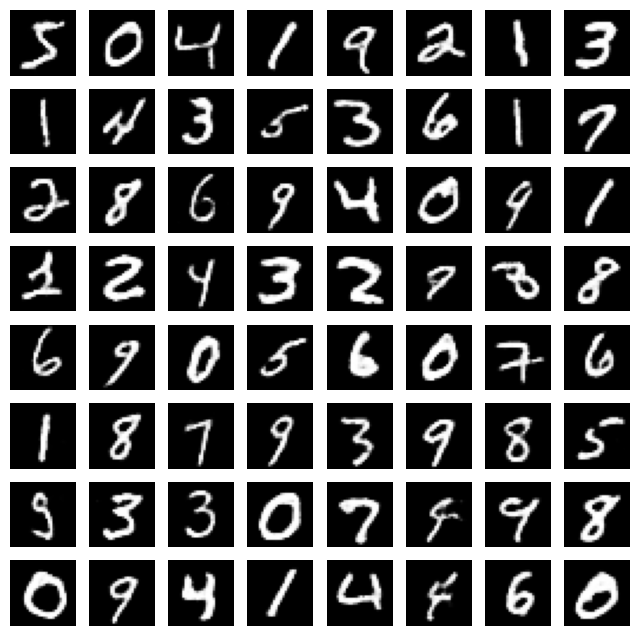

In [8]:
x=data[:64].to(Device)
x=x.view(64,1,28,28)
x=model(x)[2]
x = x[:64].view(8, 8, 28, 28)
x = x.detach().to('cpu')
image_np = x.numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels

plt.show()

In [20]:
igt=iGPT(128,8,49,3,100)
lr_rate=0.001
epochs=40
igt=igt.to(Device)
criterion=nn.CrossEntropyLoss()
optimizer2=optim.Adam(igt.parameters(),lr=0.001)

In [17]:
'''from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
import math

# Set hyperparameters
num_warmup_steps = 1000
num_total_steps = 100000  # Adjust based on your specific training scenario
base_learning_rate = 1e-3  # Adjust based on your specific requirements


# Create Adam optimizer2
optimizer2 = Adam(igt.parameters(), lr=base_learning_rate)

# Learning rate schedule with warmup and cosine decay
def lr_lambda(current_step):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    progress = float(current_step - num_warmup_steps) / float(max(1, num_total_steps - num_warmup_steps))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

# Set up the learning rate scheduler
scheduler = LambdaLR(optimizer2, lr_lambda=lr_lambda)'''


'from torch.optim import Adam\nfrom torch.optim.lr_scheduler import LambdaLR\nimport math\n\n# Set hyperparameters\nnum_warmup_steps = 1000\nnum_total_steps = 100000  # Adjust based on your specific training scenario\nbase_learning_rate = 1e-3  # Adjust based on your specific requirements\n\n\n# Create Adam optimizer2\noptimizer2 = Adam(igt.parameters(), lr=base_learning_rate)\n\n# Learning rate schedule with warmup and cosine decay\ndef lr_lambda(current_step):\n    if current_step < num_warmup_steps:\n        return float(current_step) / float(max(1, num_warmup_steps))\n    progress = float(current_step - num_warmup_steps) / float(max(1, num_total_steps - num_warmup_steps))\n    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))\n\n# Set up the learning rate scheduler\nscheduler = LambdaLR(optimizer2, lr_lambda=lr_lambda)'

In [26]:
loss_list=[]
for epoch in  range(epochs):
  count=0
  total_loss=0
  for input,_ in trainloader:
    b,c,c=input.shape
    input=input.view(b,1,c,c).to(Device)

    latent=model.encoder(input)
    latent=model.codebook.get_emb_token_all(latent)

    b,c,c=latent.shape
    latent=latent.view(b,c*c)
    target_latent=latent

    new_column = torch.full((b, 1), 100).to(Device)
    latent = torch.cat((new_column, latent[:, :-1]), dim=1)
    pred=igt(latent.long().detach())
    B,T,C=pred.shape
    pred=pred.view(B*T,C)
    target_latent=target_latent.view(B*T)
    target_latent=target_latent.view(B*T).long()
    #print(torch.argmax(pred,-1).view(b,7,7),target_latent.view(b,7,7))
    loss=criterion(pred,target_latent)
    total_loss+=loss.item()
    count+=1

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    #scheduler.step()

  loss_list.append(total_loss)
  print(f'avg_training_loss={total_loss/count},total_loss={total_loss},epoch={epoch}')

avg_training_loss=1.069070102563545,total_loss=501.39387810230255,epoch=0
avg_training_loss=1.0599830117561162,total_loss=497.13203251361847,epoch=1
avg_training_loss=1.0526590332039383,total_loss=493.6970865726471,epoch=2
avg_training_loss=1.0462332329770396,total_loss=490.68338626623154,epoch=3
avg_training_loss=1.0397752786496046,total_loss=487.6546056866646,epoch=4
avg_training_loss=1.0340307329509304,total_loss=484.96041375398636,epoch=5
avg_training_loss=1.0288421859873382,total_loss=482.5269852280617,epoch=6
avg_training_loss=1.0231671905212565,total_loss=479.8654123544693,epoch=7
avg_training_loss=1.0178274035707975,total_loss=477.361052274704,epoch=8
avg_training_loss=1.0132261194399934,total_loss=475.2030500173569,epoch=9
avg_training_loss=1.008514247469302,total_loss=472.9931820631027,epoch=10
avg_training_loss=1.0042913806463865,total_loss=471.0126575231552,epoch=11
avg_training_loss=1.000216383161321,total_loss=469.1014837026596,epoch=12
avg_training_loss=0.995965929554977

KeyboardInterrupt: 

tensor([[ 1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1, 25,  5, 96,  1],
        [ 1,  1, 66, 89, 79,  1,  1],
        [ 1,  1,  2, 58, 14, 29,  1],
        [ 1,  1, 42, 27, 39, 86,  1],
        [ 1, 13, 25, 30, 43,  1,  1],
        [ 1,  1, 79, 42,  1,  1,  1]], device='cuda:0') tensor([[ 1.,  1.,  1., 86., 86., 26.,  1.],
        [ 1.,  1., 25., 97., 21., 59.,  1.],
        [ 1.,  7., 13., 98., 95., 29.,  1.],
        [ 1.,  1.,  1., 58., 14., 29.,  1.],
        [ 1.,  1., 86., 27., 62., 86.,  1.],
        [ 1., 25., 11., 30., 43.,  1.,  1.],
        [ 1., 91., 64., 42.,  1.,  1.,  1.]], device='cuda:0')


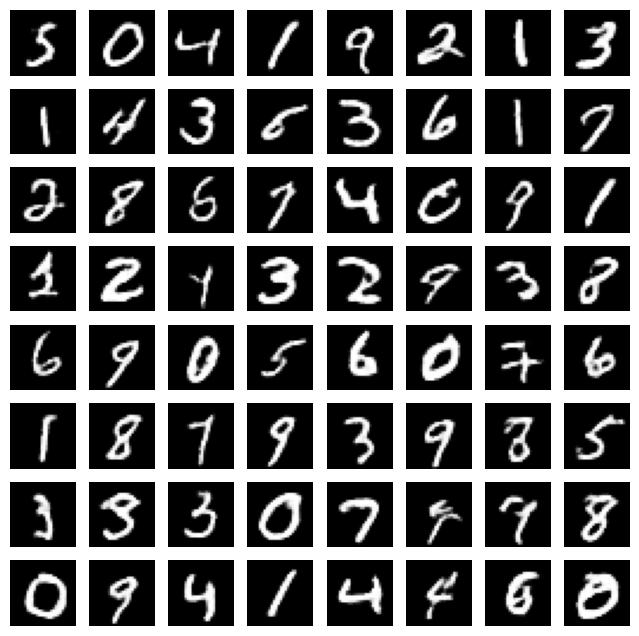

In [27]:
with torch.no_grad():
    #model.eval()
    #igt.eval()
    input=data[:64].to(Device)
    b,c,c=input.shape
    input=input.view(b,1,c,c).to(Device)
    
    latent=model.encoder(input)
    latent=model.codebook.get_emb_token_all(latent)
    
    b,c,c=latent.shape
    latent=latent.view(b,c*c)
    target_latent=latent
    
    new_column = torch.full((b, 1), 100).to(Device)
    latent = torch.cat((new_column, latent[:, :-1]), dim=1)
    x=igt(latent.long().detach())
    x=torch.argmax(x,dim=-1)
    print(x[0].view(7,7),target_latent[0].view(7,7))
    x=x.view(64,7,7)
    x=model.codebook.emb_vector(x)
    x=model.decoder(x)
    
    x = x[:64].view(8, 8, 28, 28)
    x = x.detach().to('cpu')
    image_np = x.numpy()
    
    # Create a figure and a set of subplots arranged in an 8x8 grid
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    
    # Iterate through the subplots and display each image
    for i in range(8):
        for j in range(8):
            axes[i, j].imshow(image_np[i, j], cmap='gray')
            axes[i, j].axis('off')  # Turn off axis labels
    
    plt.show()



0


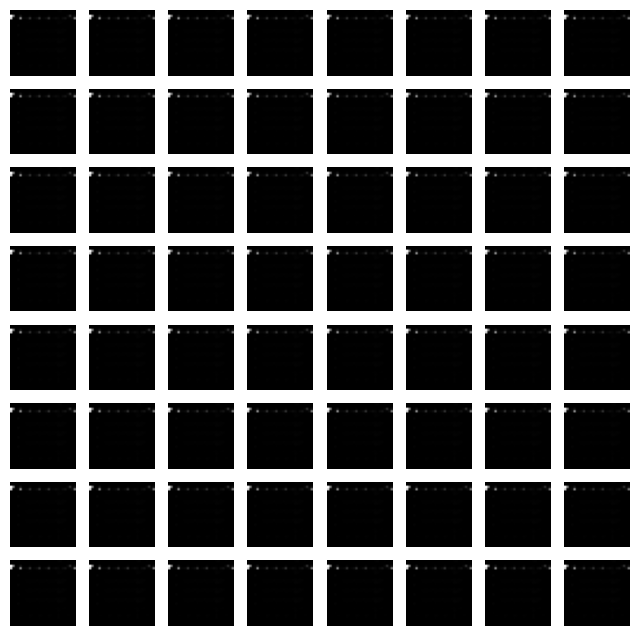

In [40]:

#model.eval()
#igt.eval()
x = torch.zeros(64,49)
y=torch.zeros(64,49)
x[:,0]=100

x=x.to(get_device())
with torch.no_grad():
  for i in range(49):
          print(i)
          out = igt(x.long())
          probs = F.softmax(out[:,i,:],dim=-1).data
          if i==48:
              y[:,i]=(torch.multinomial(probs, 1).float()).view(64)
          break
          x[:,i+1] = (torch.multinomial(probs, 1).float()).view(64)
          #print(x[:,i+1])
          print(probs,'a')
          y[:,i]=x[:,i+1]
x=y
x=x.view(64,7,7)
x=model.codebook.emb_vector(x)
x=model.decoder(x)
#x=torch.argmax(x,dim=-1)
x = x[:64].view(8, 8, 28, 28)
x = x.detach().to('cpu')
image_np = x.numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
  for j in range(8):
      axes[i, j].imshow(image_np[i, j], cmap='gray')
      axes[i, j].axis('off')  # Turn off axis labels
plt.savefig("samples.jpeg")
plt.show()